<a href="https://colab.research.google.com/github/LauJohansson/HotdogNotHotdog_and_StreetViewHouseNumbers/blob/master/Detect_housenumbers_slidingwindow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


# Loading data

Loading SVHN data

In [ ]:
batch_size = 64

train_svhn = datasets.SVHN('./data', split="train", download=True, transform=transforms.ToTensor())
train_cifar = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
train_cifar.targets = np.asarray(train_cifar.targets)
train_cifar.targets[:] = 10
trainset = torch.utils.data.ConcatDataset((train_cifar, train_svhn))

test_svhn = datasets.SVHN('./data', split="test", download=True, transform=transforms.ToTensor())
test_cifar = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())
test_cifar.targets = np.asarray(test_cifar.targets)
test_cifar.targets[:] = 10
testset = torch.utils.data.ConcatDataset((test_cifar, test_svhn))

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)

for (test_data, test_target) in train_loader:
    break
print(test_data.shape)
print(test_target)

Using downloaded and verified file: ./data/train_32x32.mat
Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat
Files already downloaded and verified
torch.Size([64, 3, 32, 32])
tensor([10,  2,  1, 10, 10,  5, 10, 10, 10,  3, 10,  5,  3, 10, 10,  5,  6,  7,
         4, 10,  2,  1, 10, 10,  6,  5,  3, 10, 10,  6, 10,  4, 10, 10, 10, 10,
         1, 10, 10,  1,  8,  5, 10,  2, 10, 10,  5,  2,  8, 10,  2, 10, 10,  0,
        10,  6,  9,  2,  7,  5,  2,  5,  1, 10])


ALT cifar data er 10!

In [ ]:
print(len(testset))

36032


Let's look at some images from our data 

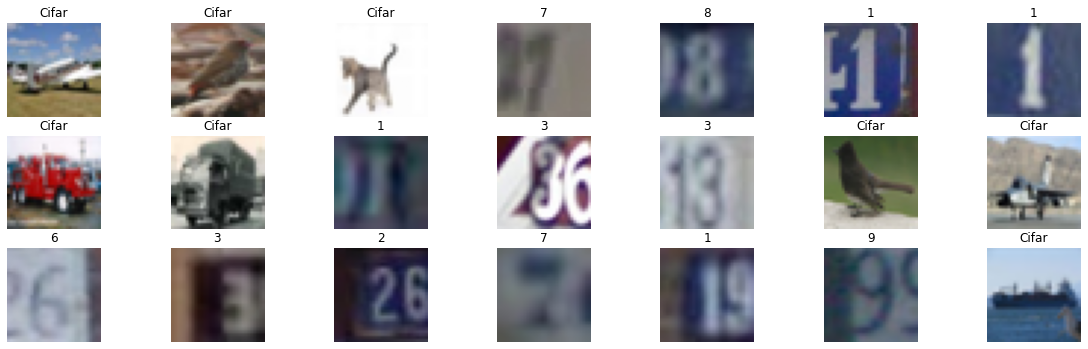

In [ ]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['0', '1','2','3','4','5','6','7','8','9','Cifar'][labels[i].item()])
    plt.axis('off')


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Now create a model and train it!


Lookin at one picture:

In [ ]:
images[0].shape

torch.Size([3, 32, 32])

It is 32 pixels

In [ ]:
pixel_size=32

Vi skal ende med 10 channels!

In [ ]:
#Layer A (3x3)
in_channels_l1=3
out_channels_l1=11
k_size_l1=3 #kernel size
stride_l1=1
padding_is_l1=int(np.floor((k_size_l1-1)/2))


#layer B 1x1 conv
in_channels_l2=11
out_channels_l2=11
k_size_l2=1 #kernel size
stride_l2=1
padding_is_l2=int(np.floor((k_size_l2-1)/2))


#layer C 1x1 conv
in_channels_l3=11
out_channels_l3=11
k_size_l3=1 #kernel size
stride_l3=1
padding_is_l3=int(np.floor((k_size_l3-1)/2))


n_targets=11

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.Convolutional = nn.Sequential(
            ## Layer A: 3x3
            #nn.Conv2d(in_channels_l1,out_channels_l1,k_size_l1,stride_l1,padding_is_l1),
            nn.Conv2d(in_channels_l1,out_channels_l1,k_size_l1,stride_l1,0),
            nn.ReLU(),
            #nn.BatchNorm2d(6),
            
            ## maxpool 2x2
            nn.MaxPool2d(2),

            #Ekstra conv layer
            nn.Conv2d(out_channels_l1,out_channels_l1,3,1,1),
            nn.ReLU(),

            #Maxpool 3x3
            nn.MaxPool2d(3),

            #Layer B (1x1)
            nn.Conv2d(in_channels_l2,out_channels_l2,5,stride_l2,padding_is_l2),
            #nn.ReLU(),

            nn.Softmax(dim=1)

            #Layer C (1x1)
            #nn.Conv2d(in_channels_l3,out_channels_l3,k_size_l3,stride_l3,padding_is_l3),
            #nn.ReLU(),
            
        )

        #self.fully_connected = nn.Sequential(
        #    # halveret antal pixel (128/2) og fordoblet channelts fra 3->6
        #    nn.Linear(5*5*10,1000),
        ##    nn.ReLU(),
          #  nn.Dropout(0.5),
          ##  nn.Linear(1000,1000),
           # nn.ReLU(),
           # nn.Dropout(0.5),
           # nn.Linear(1000,n_targets),
           # nn.Softmax(dim=1)
            
        #)
    def forward(self, x):
        x=self.Convolutional(x)
        #print(x.shape)

        #x=x.view(x.size(0),-1)       

        #x=self.fully_connected(x)
        return x

In [ ]:
#Initialize model
model = Network()
model.to(device)

#Initialize the optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #0.001


#Use saved model:
#model.load_state_dict(torch.load('drive/My Drive/DLiCV_project/Project1/model_saved_'+dato))
#optimizer.load_state_dict(torch.load('drive/My Drive/DLiCV_project/Project1/optim_saved_'+dato))

In [ ]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=50):
    def loss_fun(output, target):
        #print("loss_fun output:")
        #print(output.shape)
        #print(target.shape)
        return F.nll_loss(torch.log(output), target)
        #return F.nll_loss(output, target)
        #return nn.CrossEntropyLoss(output,target)
        
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #print(target.shape)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #print(output)
            #print(output[0].sum())
            #Compute the loss
            loss = loss_fun(output.squeeze(), target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.squeeze().argmax(1) #Lau ændret squeeze
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output.squeeze(), target).cpu().item())#Lau ændret squeeze
            predicted = output.squeeze().argmax(1) #Lau ændret squeeze
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

In [ ]:
output = train(model, optimizer)


Loss train: 1.676	 test: 1.784	 Accuracy train: 45.5%	 test: 38.7%



Loss train: 1.373	 test: 1.528	 Accuracy train: 53.9%	 test: 50.0%



Loss train: 1.169	 test: 1.381	 Accuracy train: 62.9%	 test: 56.4%



Loss train: 1.032	 test: 1.248	 Accuracy train: 68.1%	 test: 62.0%



Loss train: 0.942	 test: 1.174	 Accuracy train: 71.2%	 test: 64.5%



Loss train: 0.874	 test: 1.107	 Accuracy train: 73.5%	 test: 67.2%



Loss train: 0.822	 test: 1.075	 Accuracy train: 75.2%	 test: 68.8%



Loss train: 0.780	 test: 1.023	 Accuracy train: 76.7%	 test: 70.4%



Loss train: 0.746	 test: 1.005	 Accuracy train: 77.9%	 test: 71.1%



Loss train: 0.717	 test: 0.975	 Accuracy train: 78.9%	 test: 72.4%



Loss train: 0.692	 test: 0.928	 Accuracy train: 79.8%	 test: 74.0%



Loss train: 0.668	 test: 0.903	 Accuracy train: 80.6%	 test: 74.5%



Loss train: 0.648	 test: 0.869	 Accuracy train: 81.3%	 test: 75.7%



Loss train: 0.629	 test: 0.860	 Accuracy train: 81.9%	 test: 76.1%



Loss train: 0.612	 test: 0.817	 Accuracy train: 82.4%	 test: 77.1%



Loss train: 0.596	 test: 0.792	 Accuracy train: 83.0%	 test: 78.0%



Loss train: 0.582	 test: 0.775	 Accuracy train: 83.4%	 test: 78.3%



Loss train: 0.569	 test: 0.755	 Accuracy train: 83.9%	 test: 78.6%



Loss train: 0.557	 test: 0.743	 Accuracy train: 84.3%	 test: 79.3%



Loss train: 0.546	 test: 0.724	 Accuracy train: 84.7%	 test: 80.0%



Loss train: 0.535	 test: 0.723	 Accuracy train: 85.0%	 test: 80.0%



Loss train: 0.526	 test: 0.739	 Accuracy train: 85.3%	 test: 80.0%



Loss train: 0.518	 test: 0.706	 Accuracy train: 85.5%	 test: 80.7%



Loss train: 0.510	 test: 0.685	 Accuracy train: 85.8%	 test: 81.1%



Loss train: 0.504	 test: 0.680	 Accuracy train: 86.0%	 test: 81.4%



Loss train: 0.497	 test: 0.657	 Accuracy train: 86.2%	 test: 81.9%



Loss train: 0.491	 test: 0.651	 Accuracy train: 86.4%	 test: 82.1%



Loss train: 0.485	 test: 0.644	 Accuracy train: 86.6%	 test: 82.2%



Loss train: 0.480	 test: 0.644	 Accuracy train: 86.7%	 test: 82.3%



Loss train: 0.475	 test: 0.634	 Accuracy train: 86.9%	 test: 82.7%



Loss train: 0.471	 test: 0.636	 Accuracy train: 87.0%	 test: 82.5%



Loss train: 0.467	 test: 0.641	 Accuracy train: 87.1%	 test: 82.6%



Loss train: 0.463	 test: 0.624	 Accuracy train: 87.2%	 test: 83.1%



Loss train: 0.459	 test: 0.614	 Accuracy train: 87.4%	 test: 83.4%



Loss train: 0.455	 test: 0.608	 Accuracy train: 87.4%	 test: 83.2%



Loss train: 0.453	 test: 0.617	 Accuracy train: 87.6%	 test: 83.4%



Loss train: 0.450	 test: 0.613	 Accuracy train: 87.7%	 test: 83.4%



Loss train: 0.446	 test: 0.605	 Accuracy train: 87.7%	 test: 83.6%



Loss train: 0.443	 test: 0.604	 Accuracy train: 87.8%	 test: 83.6%



Loss train: 0.441	 test: 0.596	 Accuracy train: 87.9%	 test: 83.9%



Loss train: 0.438	 test: 0.588	 Accuracy train: 87.9%	 test: 84.0%



Loss train: 0.435	 test: 0.581	 Accuracy train: 88.0%	 test: 84.3%



Loss train: 0.433	 test: 0.590	 Accuracy train: 88.1%	 test: 84.2%



Loss train: 0.431	 test: 0.581	 Accuracy train: 88.2%	 test: 84.2%



Loss train: 0.428	 test: 0.573	 Accuracy train: 88.2%	 test: 84.1%



Loss train: 0.426	 test: 0.571	 Accuracy train: 88.2%	 test: 84.4%



Loss train: 0.424	 test: 0.572	 Accuracy train: 88.3%	 test: 84.4%



Loss train: 0.422	 test: 0.574	 Accuracy train: 88.4%	 test: 84.5%



Loss train: 0.420	 test: 0.580	 Accuracy train: 88.4%	 test: 84.3%



Loss train: 0.419	 test: 0.565	 Accuracy train: 88.5%	 test: 84.8%



Text(0, 0.5, 'Loss')

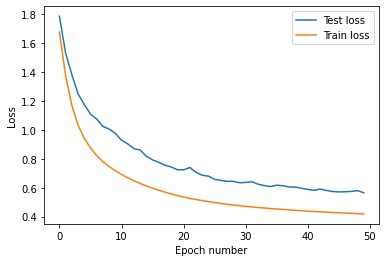

In [ ]:
plt.plot(output['test_loss'])
plt.plot(output['train_loss'])
plt.legend(('Test loss','Train loss'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')

# Prediction

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (20,4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
import torchvision

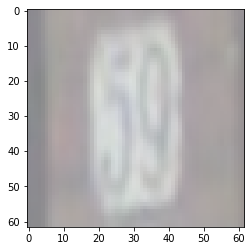

In [ ]:
imshow(torchvision.utils.make_grid(images[0:1]))

In [ ]:
outputs_predict = model(images[0:1].to(device))

In [ ]:
np.argmax(outputs_predict.detach().cpu())

tensor(104)

In [ ]:
_, predicted = torch.max(outputs_predict, 1)

#print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
#                              for j in range(8)))

In [ ]:
predicted

tensor([[[1, 2, 4, 0, 1, 2],
         [1, 4, 3, 0, 0, 7],
         [1, 5, 1, 1, 4, 5],
         [1, 5, 3, 9, 1, 6],
         [1, 2, 2, 2, 1, 7],
         [1, 2, 2, 2, 4, 7]]], device='cuda:0')

# Loading full images - Sliding Window

In [ ]:
import gdown

In [ ]:
if not os.path.exists('./SVHN'):
#  import gdown
  url = 'https://drive.google.com/uc?id=1YneBiiNWt6mEa5STYWtT5XlDb_6JeDpg'
  gdown.download(url, './SVHN.zip', quiet=False)
  !unzip ./SVHN.zip > /dev/null

Brugt til at unzippe

In [ ]:
#import zipfile
#from google.colab import drive
#drive.mount('/content/drive/')

#zip_ref = zipfile.ZipFile("/content/SVHN.zip", 'r')
#zip_ref.extractall("/tmp")
#zip_ref.close()

In [ ]:
class Full_SVHN(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='./SVHN'): #NY
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        #image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes= ['Unknown' for d in glob.glob(data_path +'/*') ]
        image_classes.sort()
        #self.name_to_label = {c: id for id, c in enumerate(image_classes)} # rbuger ikke denne
        self.image_paths = glob.glob(data_path + '/*.png')
        #self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        #c = os.path.split(os.path.split(image_path)[0])[1]
        c='Unknown'
        #y = self.name_to_label[c]
        y=0
        X = self.transform(image)
        return X, y

In [ ]:
#This is not correct! (but smart when looking at the pictures)
size = 62
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), #
                                    transforms.ToTensor()])

#COrrect: can take all
#train_transform = transforms.Compose([ transforms.Pad(20),
#                                    transforms.ToTensor()])
#test_transform = transforms.Compose([transforms.Pad(20),
#                                    transforms.ToTensor()])


batch_size = 64
trainset = Full_SVHN(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testset = Full_SVHN(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
print(len(trainset))

33402


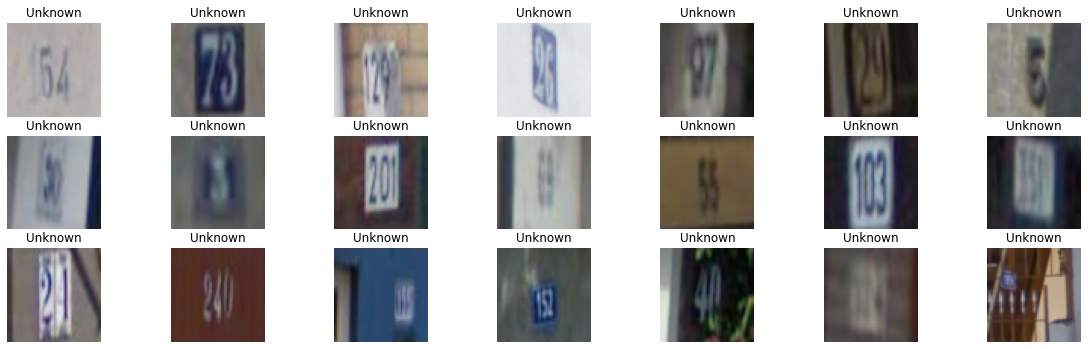

In [ ]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

#plotting virker ikke!
for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['Unknown'][labels[i].item()])
    plt.axis('off')

#imshow(torchvision.utils.make_grid(images))


Passing image to the network:

In [ ]:
#Correct
#outputs_predict = model(images.to(device))

#Not correct
outputs_predict = model(images[17:18].to(device))

Finding the predicted class and the prob values:

In [ ]:
value, predicted = torch.max(outputs_predict, 1)

Using threshold 0.90 and change the values to background:

In [ ]:
predicted

tensor([[[1, 4, 4, 2, 0, 1],
         [1, 4, 2, 3, 5, 7],
         [1, 3, 6, 5, 5, 0],
         [1, 1, 3, 3, 0, 7],
         [1, 1, 2, 2, 4, 0],
         [1, 2, 4, 9, 2, 0]]], device='cuda:0')

In [ ]:
predicted[value<0.60]=10
print(predicted)

tensor([[[10, 10, 10, 10, 10, 10],
         [10, 10, 10, 10, 10, 10],
         [10, 10, 10, 10, 10, 10],
         [10, 10, 10, 10, 10, 10],
         [10,  1,  2, 10, 10, 10],
         [10, 10, 10, 10, 10, 10]]], device='cuda:0')


Looking at the predictions:

In [ ]:
Predict_final=predicted
print(Predict_final)

tensor([[[10, 10, 10, 10, 10, 10],
         [10, 10, 10, 10, 10, 10],
         [10, 10, 10, 10, 10, 10],
         [10, 10, 10, 10, 10, 10],
         [10,  1,  2, 10, 10, 10],
         [10, 10, 10, 10, 10, 10]]], device='cuda:0')


In [ ]:
value

tensor([[[0.5009, 0.3468, 0.3185, 0.3683, 0.2570, 0.1854],
         [0.5494, 0.3898, 0.3703, 0.3321, 0.2208, 0.2515],
         [0.4286, 0.2691, 0.3335, 0.5770, 0.3257, 0.2426],
         [0.3274, 0.5285, 0.2704, 0.3272, 0.4123, 0.3126],
         [0.4457, 0.6718, 0.7185, 0.4111, 0.5039, 0.3123],
         [0.4273, 0.3590, 0.3880, 0.5037, 0.4610, 0.2102]]], device='cuda:0',
       grad_fn=<MaxBackward0>)

## Draw rectangles (does not work correct)

https://stackoverflow.com/questions/37435369/matplotlib-how-to-draw-a-rectangle-on-image

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

In [ ]:


x=0
y=int(images[17:18][0].permute(1,2,0).shape[0]/6)


In [ ]:
h=int(images[17:18][0].permute(1,2,0).shape[0]/6)
b=h

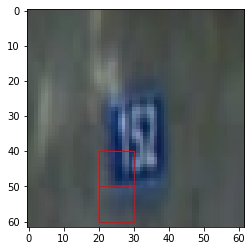

In [ ]:
fig,ax = plt.subplots(1)
# Display the image
ax.imshow(images[17:18][0].permute(1,2,0).detach().cpu().numpy())
for i in range (Predict_final.shape[1]):
  for j in range (Predict_final.shape[2]):
    if Predict_final[0][-i][-j]!=10:
      # Create a Rectangle patch
      
      rect = patches.Rectangle((i*b,h*j),h,b,linewidth=1,edgecolor='r',facecolor='none')
      ax.add_patch(rect)


plt.show()

## Looking at possibilities for numbers classified in image

In [ ]:
outputs_predict[0][10] #SSH for at det er baggrund

tensor([[1.2156e-03, 4.6180e-02, 1.8261e-02, 9.7786e-01, 9.7627e-01, 9.8095e-01],
        [2.1943e-04, 6.9591e-03, 1.7572e-02, 3.8864e-01, 6.3210e-01, 9.6611e-01],
        [5.7975e-04, 8.4801e-04, 8.0813e-05, 1.6110e-02, 7.8350e-02, 3.8911e-01],
        [7.2000e-03, 1.4587e-02, 1.2816e-03, 9.3042e-03, 1.9666e-02, 1.2494e-01],
        [5.4652e-02, 1.2937e-01, 1.4976e-02, 3.0070e-03, 6.7791e-02, 1.1777e-01],
        [1.6564e-02, 8.6330e-01, 1.2322e-01, 9.2219e-02, 1.1824e-01, 9.7953e-02]],
       device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
outputs_predict[0][0] #SSH for 0

tensor([[1.0716e-01, 3.8479e-03, 9.9512e-07, 2.4513e-09, 2.2232e-08, 5.2438e-06],
        [3.0940e-02, 3.6382e-02, 1.3523e-03, 5.4532e-07, 7.2866e-07, 1.7738e-04],
        [2.5848e-01, 3.0040e-03, 2.6832e-03, 1.5785e-02, 1.4890e-03, 1.1323e-02],
        [1.9355e-02, 1.0114e-02, 1.6003e-03, 2.6676e-02, 3.9572e-01, 1.1305e-01],
        [1.2639e-03, 4.0933e-05, 2.0777e-06, 5.5497e-04, 1.7412e-01, 3.4698e-01],
        [9.7187e-03, 3.3854e-05, 5.2180e-07, 1.9888e-04, 8.3478e-03, 1.1708e-01]],
       device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
outputs_predict[0][1] #SSH for 1

tensor([[5.3523e-01, 1.6038e-01, 6.7699e-07, 6.0519e-09, 7.5879e-08, 7.0698e-04],
        [6.4393e-01, 6.8886e-02, 4.9784e-05, 1.2333e-05, 3.7389e-05, 1.3178e-02],
        [3.9162e-01, 9.6999e-01, 4.7859e-03, 8.0178e-06, 2.9604e-03, 1.5324e-01],
        [2.1451e-01, 7.4633e-01, 3.6033e-04, 2.1962e-05, 4.6171e-01, 2.4852e-01],
        [2.8784e-01, 1.3467e-02, 1.4444e-05, 6.8732e-07, 6.6833e-01, 2.5241e-01],
        [3.7001e-01, 1.4641e-03, 5.5757e-06, 4.2869e-04, 4.6796e-01, 7.1805e-03]],
       device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
outputs_predict[0][2] #SSH for 2

tensor([[5.2284e-02, 3.7838e-03, 6.3748e-05, 1.3664e-04, 3.0814e-05, 1.2059e-04],
        [4.0645e-04, 4.3810e-03, 5.7924e-02, 2.5224e-04, 5.5888e-05, 2.1674e-03],
        [6.4262e-04, 1.7494e-03, 9.1012e-01, 6.4622e-03, 2.7302e-05, 4.2108e-03],
        [6.5067e-03, 1.6477e-01, 7.1617e-01, 1.1694e-03, 4.0259e-05, 4.6821e-03],
        [1.2358e-01, 9.1917e-03, 9.9135e-04, 8.8864e-04, 8.1592e-04, 1.6731e-02],
        [3.1357e-02, 1.2172e-04, 3.7180e-04, 1.7257e-01, 8.6549e-03, 1.6114e-02]],
       device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
outputs_predict[0][3] #SSH for 3

tensor([[5.0528e-02, 8.3747e-02, 4.6114e-01, 1.6927e-03, 1.2967e-02, 1.6204e-02],
        [4.8985e-02, 3.9546e-02, 2.8827e-01, 4.4742e-01, 4.1692e-02, 1.8591e-03],
        [9.0770e-02, 2.8649e-03, 4.5741e-04, 3.2805e-01, 5.6865e-02, 7.2454e-03],
        [4.6638e-02, 3.7656e-03, 3.8737e-02, 1.5973e-01, 1.8546e-03, 4.1975e-03],
        [1.9164e-01, 9.4836e-02, 1.3074e-01, 6.3849e-02, 3.0069e-03, 1.6973e-03],
        [4.5597e-01, 7.3027e-02, 1.2105e-01, 2.0377e-01, 8.8613e-04, 1.4306e-03]],
       device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
outputs_predict[0][4] #SSH for 4

tensor([[6.8924e-02, 3.4092e-01, 1.6539e-05, 9.5672e-08, 2.3067e-06, 1.0562e-04],
        [1.0836e-01, 7.7147e-03, 4.6738e-05, 3.5981e-05, 1.2617e-05, 1.1577e-03],
        [1.9769e-01, 1.9641e-03, 7.0585e-05, 2.4616e-04, 6.1574e-07, 2.7746e-04],
        [5.4415e-01, 5.2698e-02, 1.0519e-01, 4.8528e-01, 5.8201e-04, 5.3892e-04],
        [1.1522e-01, 6.2485e-01, 2.8842e-01, 5.1071e-03, 2.4977e-02, 4.7443e-02],
        [3.2892e-02, 2.3132e-02, 1.9471e-03, 3.2430e-04, 3.6066e-01, 6.6770e-01]],
       device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
outputs_predict[0][5] #SSH for 5

tensor([[4.1104e-03, 9.9606e-03, 4.7543e-01, 1.9776e-02, 9.9419e-03, 9.6389e-04],
        [1.8544e-03, 3.9535e-02, 2.5299e-01, 1.2310e-01, 1.5469e-01, 2.1040e-03],
        [7.0022e-03, 5.1698e-05, 3.1755e-05, 4.6121e-01, 1.0591e-02, 2.0818e-03],
        [3.0625e-03, 9.8766e-05, 8.6158e-04, 2.1489e-02, 3.3222e-04, 1.5576e-03],
        [8.9673e-03, 3.5795e-03, 2.2790e-01, 1.5721e-02, 2.1792e-04, 3.4290e-03],
        [6.2868e-03, 1.3511e-02, 6.1085e-01, 3.0963e-02, 1.9166e-04, 1.7682e-03]],
       device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
outputs_predict[0][6] #SSH for 6

tensor([[9.9247e-03, 2.3468e-01, 3.8694e-02, 3.5177e-04, 4.2471e-05, 7.9171e-06],
        [2.9672e-02, 6.1594e-01, 1.7471e-01, 7.2653e-03, 1.3876e-02, 2.4440e-04],
        [1.0426e-02, 1.3528e-03, 2.0131e-02, 8.9585e-02, 1.5826e-03, 2.6264e-03],
        [8.3702e-04, 3.0797e-04, 2.0258e-02, 1.1035e-02, 4.3684e-03, 2.5435e-02],
        [3.3745e-03, 2.1747e-03, 7.8336e-02, 6.1661e-04, 8.3600e-04, 5.6714e-02],
        [2.7740e-03, 1.5024e-02, 5.3722e-02, 7.5995e-04, 2.1508e-04, 1.7935e-02]],
       device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
outputs_predict[0][7] #SSH for 7

tensor([[1.2598e-01, 1.4490e-02, 1.2439e-03, 4.4704e-05, 1.0249e-04, 1.8334e-04],
        [2.0062e-03, 2.8128e-03, 3.8085e-02, 3.4069e-03, 3.1509e-02, 4.6880e-03],
        [4.6375e-03, 6.5564e-03, 1.6773e-02, 1.0679e-02, 8.4240e-01, 3.9428e-01],
        [7.4382e-04, 8.3183e-04, 1.9785e-03, 5.3396e-04, 1.0192e-01, 4.2012e-01],
        [2.8038e-03, 1.4504e-05, 2.3961e-07, 2.5413e-06, 1.1015e-02, 5.9694e-02],
        [5.5611e-03, 1.4771e-05, 6.7950e-07, 4.6937e-05, 1.2137e-03, 5.0797e-03]],
       device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
outputs_predict[0][8] #SSH for 8

tensor([[3.1372e-02, 9.9517e-02, 4.8652e-03, 1.2889e-04, 5.5484e-05, 1.7176e-05],
        [1.2210e-01, 5.8948e-02, 1.4130e-01, 2.9788e-02, 1.1519e-01, 6.5068e-03],
        [4.8166e-03, 1.9132e-03, 3.9043e-02, 5.6457e-02, 5.1888e-03, 3.4756e-02],
        [4.2521e-02, 5.4935e-03, 1.0408e-01, 3.9805e-02, 9.7669e-03, 5.3916e-02],
        [1.8090e-01, 1.2090e-01, 1.4775e-01, 2.4702e-02, 1.1842e-02, 8.8757e-02],
        [4.5030e-02, 8.5257e-03, 3.6775e-02, 2.4075e-01, 1.5279e-02, 6.3804e-02]],
       device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
outputs_predict[0][9]#SSH for 9

tensor([[1.3268e-02, 2.5042e-03, 2.8003e-04, 1.3096e-05, 5.8710e-04, 7.3822e-04],
        [1.1524e-02, 1.1890e-01, 2.7695e-02, 8.1053e-05, 1.0834e-02, 1.8094e-03],
        [3.3325e-02, 9.7100e-03, 5.8188e-03, 1.5407e-02, 5.4818e-04, 8.4874e-04],
        [1.1448e-01, 1.0059e-03, 9.4770e-03, 2.4495e-01, 4.0426e-03, 3.0390e-03],
        [2.9755e-02, 1.5741e-03, 1.1087e-01, 8.8555e-01, 3.7050e-02, 8.3792e-03],
        [2.3840e-02, 1.8497e-03, 5.2060e-02, 2.5797e-01, 1.8352e-02, 3.9506e-03]],
       device='cuda:0', grad_fn=<SelectBackward>)